In [64]:
import torch
from torch import tensor
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.optim import optimize_acqf
import botorch.acquisition as acqf

from sklearn.datasets import make_moons
import sklearn.datasets as ds
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

## Optimizing Ridge Regression

In [65]:
# regression design points
delta = 0.1
x_coord = np.arange(-5.0, 5.0, delta)
y_coord = np.arange(-5.0, 5.0, delta)
x_coord, y_coord = np.meshgrid(x_coord, y_coord)

# BO design points
x_ = (torch.arange(0.01, 5.01, 0.01))
y_ = (torch.arange(0.01, 5.01, 0.01))
x_g, y_g = torch.meshgrid(x_, y_)
grid = torch.rot90(torch.stack((x_g, y_g), 2))

X_ = grid.reshape(500*500, 2)

In [66]:
def plot_regression(model, kernel, gamma, llambda, iteration):
    samples = np.ndarray((x_coord.shape[0], x_coord.shape[1]))
    for i in range(x_coord.shape[0]):
        for j in range(x_coord.shape[1]):
            sample = np.asarray([[x_coord[i][j], y_coord[i][j]]])
            samples[i][j] = model.predict(kernel.__call__(sample, Y=X_train))

    p, sub = plt.subplots(1, 1, figsize=(10, 10))
    rr_title = "iteration " + str(iteration) + "\nKRR - gamma=" + str(gamma) + ", lambda=" + str(llambda)
    sub.title.set_text(rr_title)
    con = sub.contour(x_coord, y_coord, samples, colors="k", levels=[0])
    sub.clabel(con, fontsize=9, inline=True)
    sub.imshow(np.flip(samples, axis=0), extent=[-5, 5, -5, 5])
    sub.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], color='violet')
    sub.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], color='darkorange')
    sub.spines['left'].set_position('center')
    sub.spines['bottom'].set_position('zero')
    sub.spines['right'].set_color('none')
    sub.spines['top'].set_color('none')
    sub.xaxis.set_ticks_position('bottom')
    sub.yaxis.set_ticks_position('left')
    plt.plot()

def plot_bo(gp: SingleTaskGP, EI: acqf.ExpectedImprovement):
    fig = plt.figure(figsize=(6, 3))

    sub2 = fig.add_subplot(1, 2, 1)
    sub2.title.set_text('Acquisition Function')
    if len(X_samples) > 1:
        sub2.scatter(X_samples[:, 0][0:-1], X_samples[:, 1][0:-1], color='white')
    sub2.scatter(X_samples[:, 0][-1], X_samples[:, 1][-1], color='red')
    X_ei = X_.unsqueeze(1)
    ei = EI(X_ei).detach().numpy().reshape(500, 500)
    sub2.imshow(ei, extent=[x_[0], x_[-1], y_[0], y_[-1]])
    sub2.spines['left'].set_position('zero')
    sub2.spines['bottom'].set_position('zero')
    sub2.spines['right'].set_color('none')
    sub2.spines['top'].set_color('none')
    sub2.xaxis.set_ticks_position('bottom')
    sub2.yaxis.set_ticks_position('left')
    sub2.set_xlabel('gamma')
    sub2.set_ylabel('lambda')

    sub3 = fig.add_subplot(1, 2, 2)
    sub3.title.set_text('GP posterior')
    posterior_mean = gp.posterior(X_).mean.detach().numpy().reshape(500, 500)
    sub3.imshow(posterior_mean, extent=[x_[0], x_[-1], y_[0], y_[-1]])
    sub3.spines['left'].set_position('zero')
    sub3.spines['bottom'].set_position('zero')
    sub3.spines['right'].set_color('none')
    sub3.spines['top'].set_color('none')
    sub3.xaxis.set_ticks_position('bottom')
    sub3.yaxis.set_ticks_position('left')
    sub3.set_xlabel('gamma')
    sub3.set_ylabel('lambda')

    plt.plot()

In [67]:
# create two moons dataset
# X, y = ds.make_moons(n_samples=1000, noise=0.3, random_state=0)
X, y = ds.make_circles(n_samples = 1000, noise = 0.02, random_state=0)
X = X*1.5

# test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

def sample_regression(gamma, llambda, iteration, K=None):
    gamma = float(gamma)
    llambda = float(llambda)

    # train
    kr = KernelRidge(alpha=0.1, gamma=gamma, kernel='precomputed')
    kernel = RBF(length_scale=gamma)
    if K is None:
        K = kernel.__call__(X_train)
    kr.fit(K, y_train)

    # test
    #predictions = kr.predict(X_test)
    predictions = kr.predict(kernel.__call__(X_test, Y=X_train))
    score = r2_score(y_test, predictions)
    plot_regression(kr, kernel, gamma, llambda, iteration)
    return tensor(score), K

## Bayesian Optimization

iteration:       0
current candidate:  tensor([[0.1675, 3.1888]])
model score for candidate:  0.9964284025791887
Added kernel matrix at iter  0
iteration:       1
stored candidate:  tensor([0.1675, 3.1888])
stored bounds:  tensor([[0.1675, 0.0100],
        [0.1675, 5.0000]])
new_candidate_stored:  tensor([[0.1675, 2.5607]])
acq_value_stored:  tensor(0.3256)
current candidate:  tensor([[0.1675, 2.5607]])
model score for candidate:  0.9964284025791887
Added kernel matrix at iter  1
iteration:       2
stored candidate:  tensor([0.1675, 3.1888])
stored bounds:  tensor([[0.1675, 0.0100],
        [0.1675, 5.0000]])
new_candidate_stored:  tensor([[0.1675, 3.6495]])
acq_value_stored:  tensor(0.0572)
stored candidate:  tensor([0.1675, 2.5607])
stored bounds:  tensor([[0.1675, 0.0100],
        [0.1675, 5.0000]])
new_candidate_stored:  tensor([[0.1675, 2.1000]])
acq_value_stored:  tensor(0.0572)
current candidate:  tensor([[0.4429, 2.8747]])
model score for candidate:  0.972154792836571
Added ker

C:\Users\Vincent\AppData\Local\Temp/ipykernel_12924/2550240854.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(6, 3))


iteration:       10
stored candidate:  tensor([0.1675, 3.1888])
stored bounds:  tensor([[0.1675, 0.0100],
        [0.1675, 5.0000]])
new_candidate_stored:  tensor([[0.1675, 3.6934]])
acq_value_stored:  tensor(0.0061)
stored candidate:  tensor([0.1675, 2.5607])
stored bounds:  tensor([[0.1675, 0.0100],
        [0.1675, 5.0000]])
new_candidate_stored:  tensor([[0.1675, 4.6108]])
acq_value_stored:  tensor(0.0063)
stored candidate:  tensor([0.1675, 1.9205])
stored bounds:  tensor([[0.1675, 0.0100],
        [0.1675, 5.0000]])
new_candidate_stored:  tensor([[0.1675, 4.6109]])
acq_value_stored:  tensor(0.0063)
stored candidate:  tensor([0.1675, 2.8747])
stored bounds:  tensor([[0.1675, 0.0100],
        [0.1675, 5.0000]])
new_candidate_stored:  tensor([[0.1675, 4.6109]])
acq_value_stored:  tensor(0.0063)
current candidate:  tensor([[0.4960, 4.8198]])
model score for candidate:  0.9701145713513236
iteration:       11
stored candidate:  tensor([0.1675, 3.1888])
stored bounds:  tensor([[0.1675, 0

[]

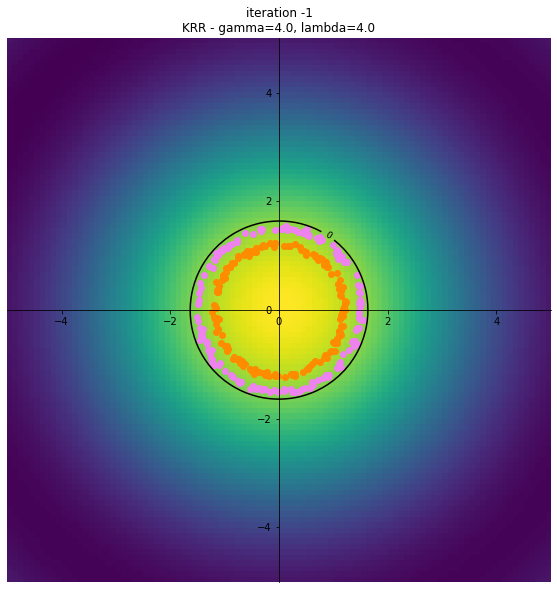

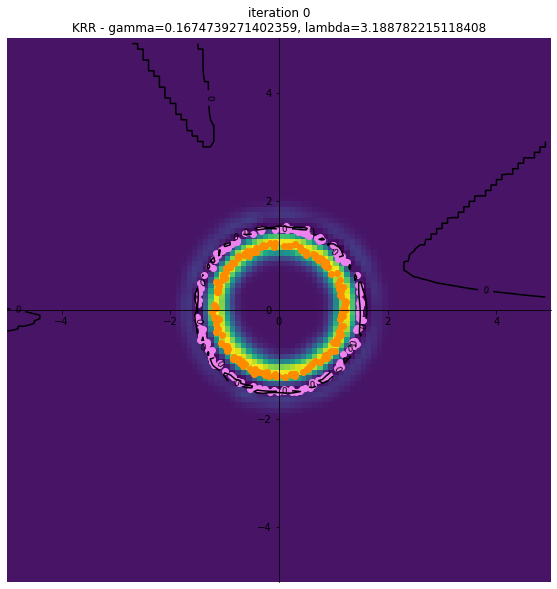

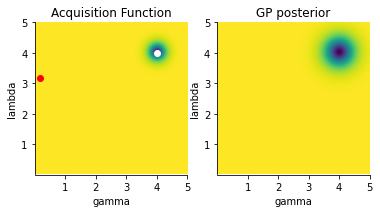

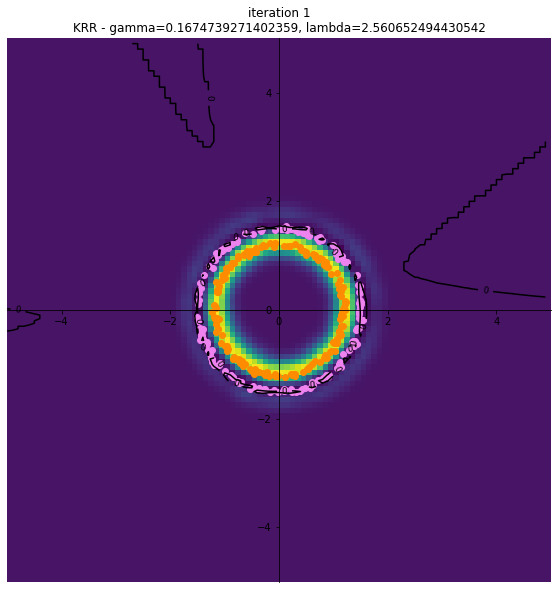

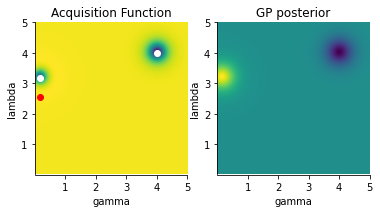

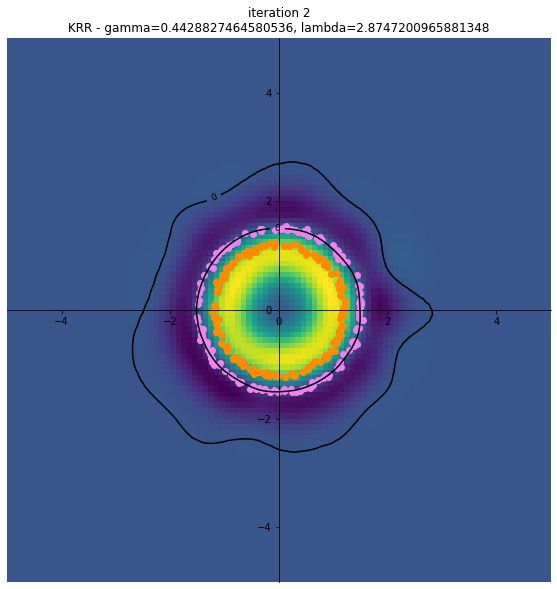

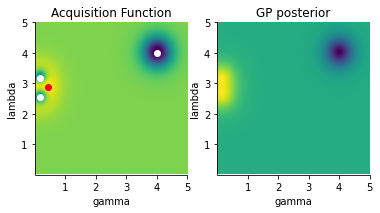

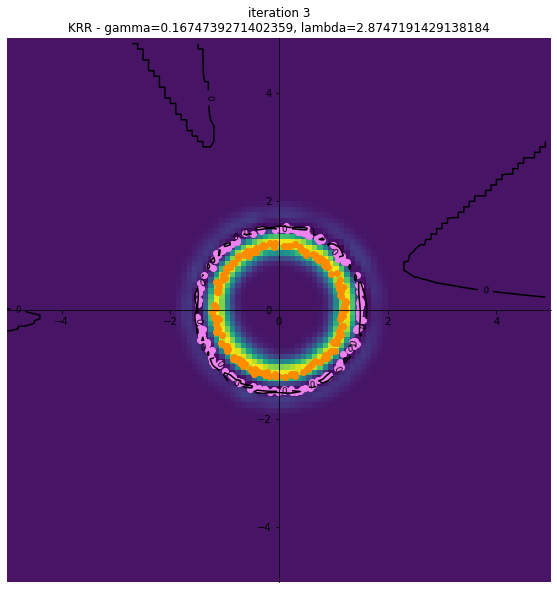

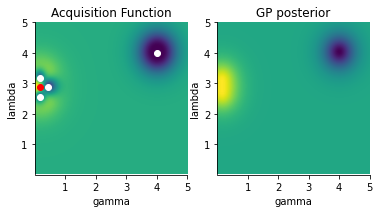

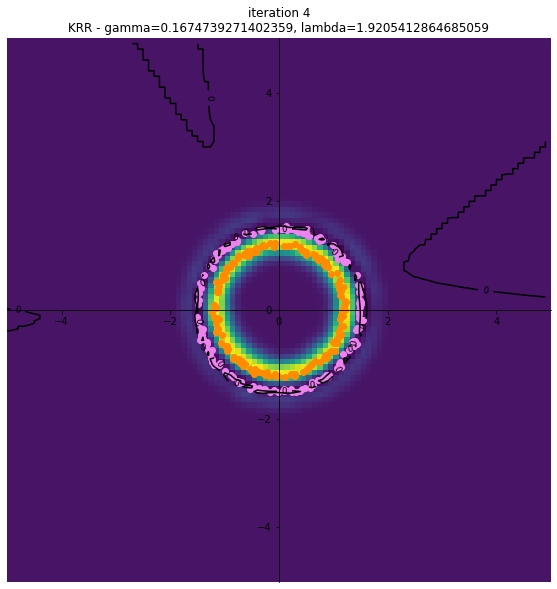

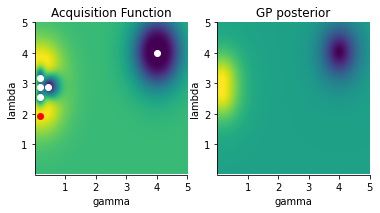

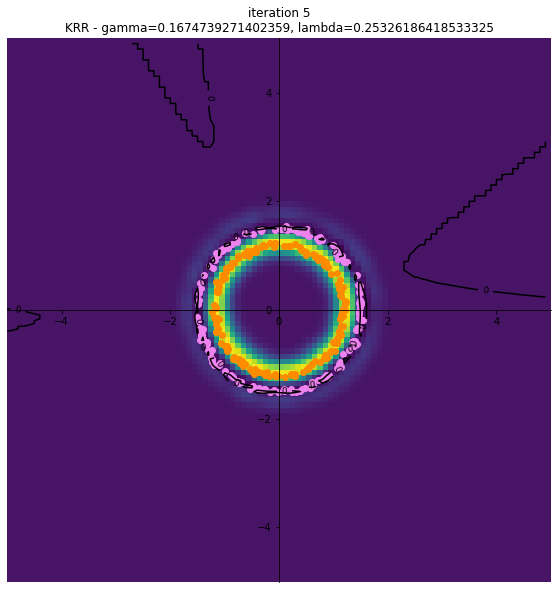

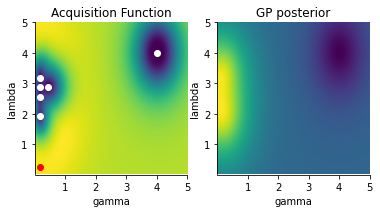

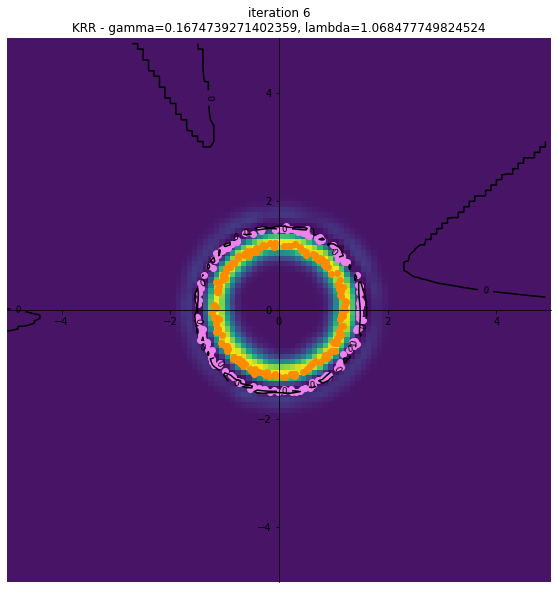

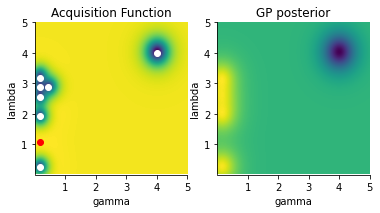

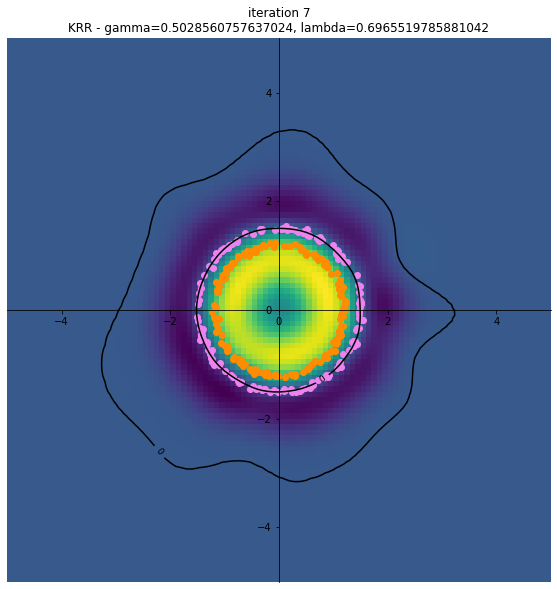

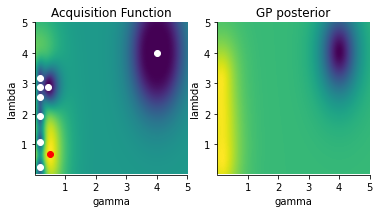

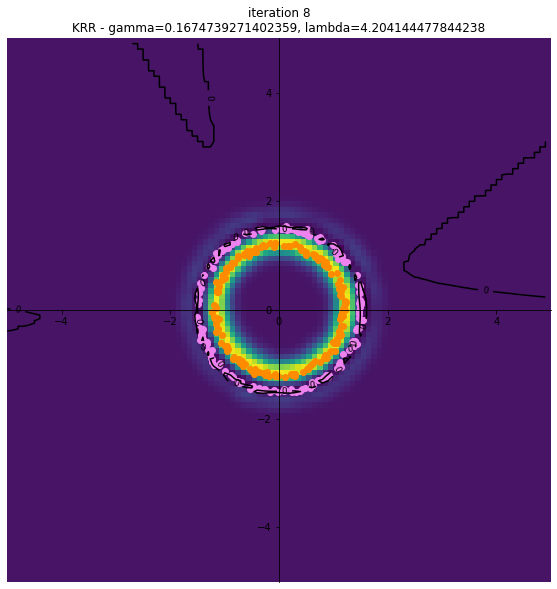

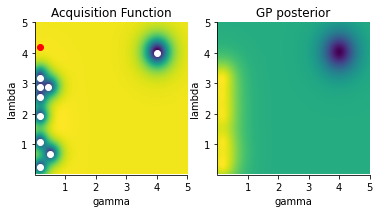

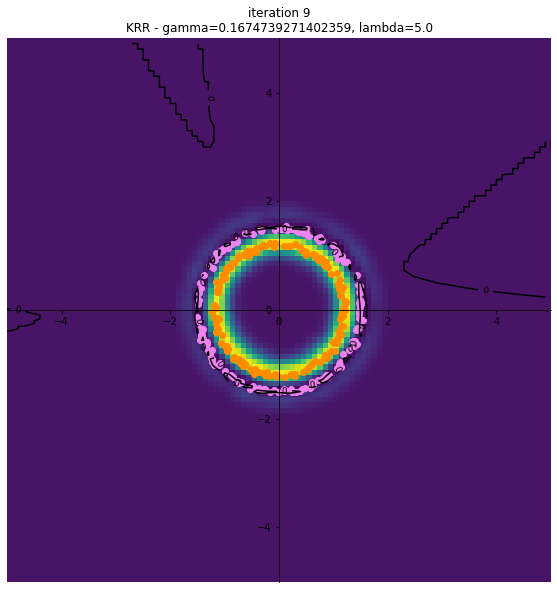

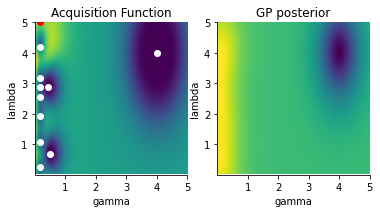

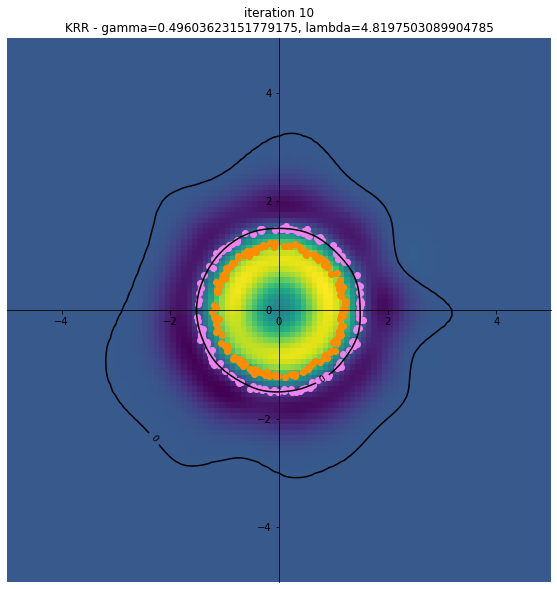

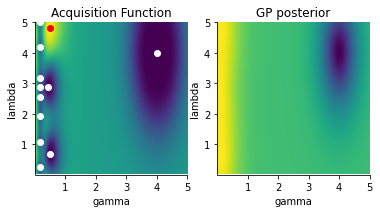

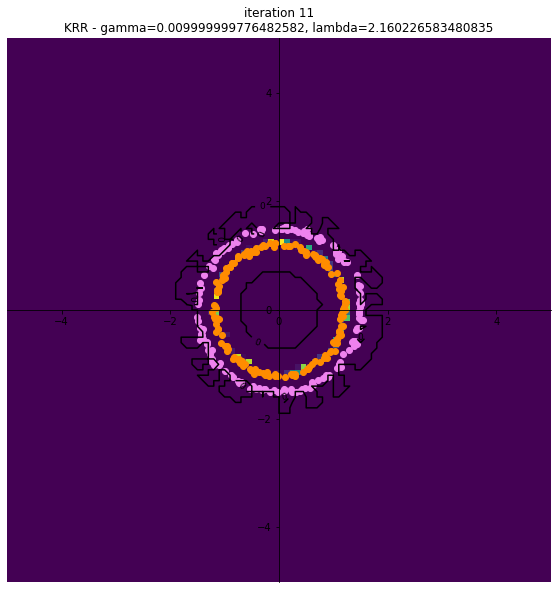

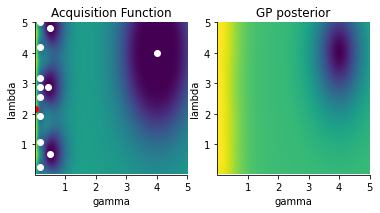

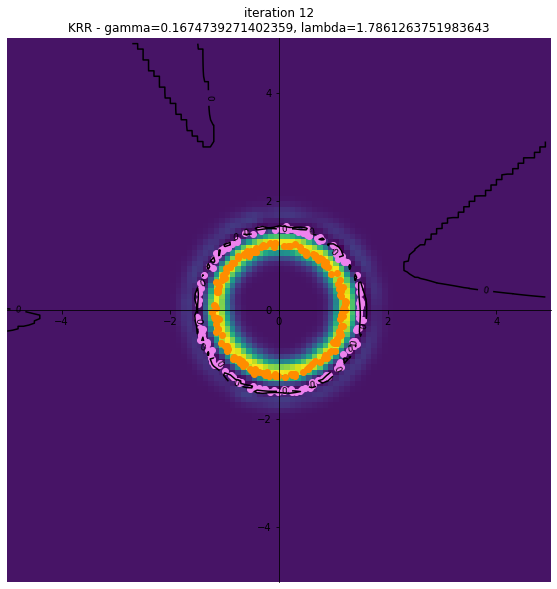

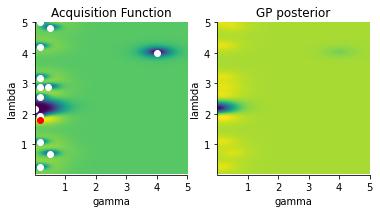

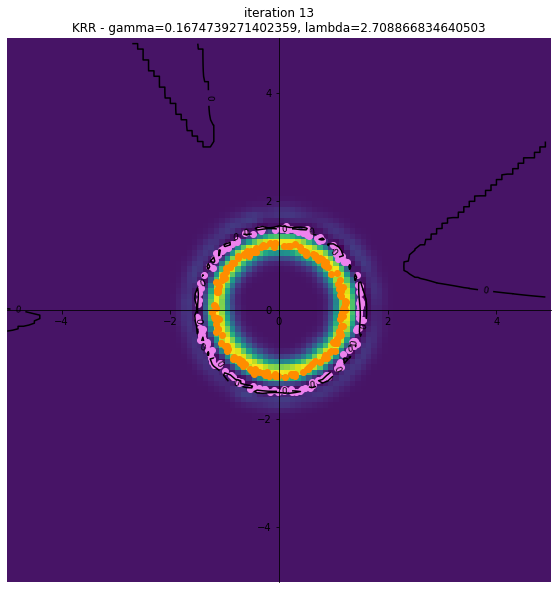

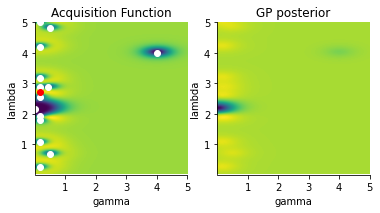

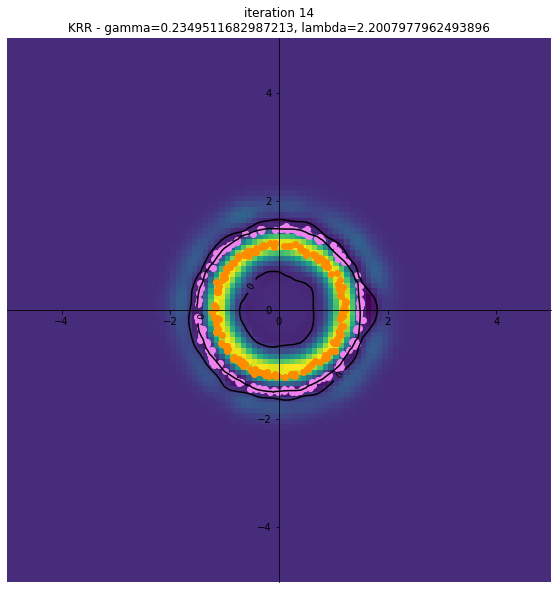

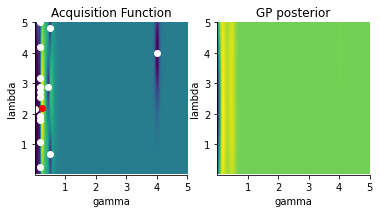

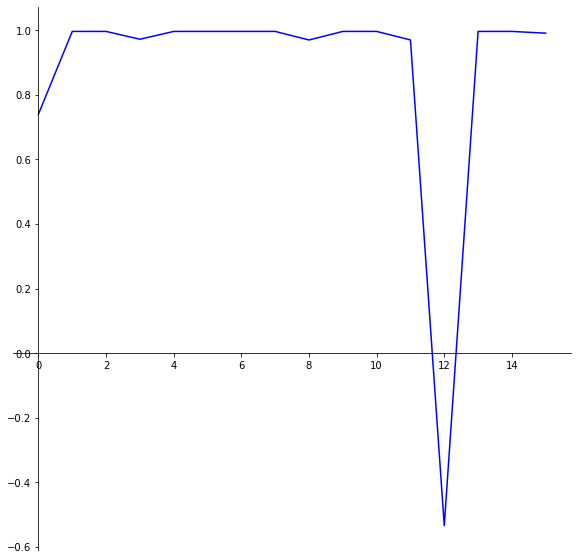

In [68]:
bounds = tensor([[x_[0], y_[0]], [x_[-1], y_[-1]]])
X_samples = tensor([[4., 4.]])
y_samples = sample_regression(X_samples[0][0], X_samples[0][1], -1)[0].reshape(-1, 1)

# EIpS stuff
max_stored_kernels = 3
kernel_matrices = []
kernel_parameters = []
kernel_evaluations = []
c_p = 0.9
c_np = 1

for i in range(15):
    print("=======================")
    print("iteration:      ", i)

    gp = SingleTaskGP(X_samples, y_samples)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_model(mll)

    EI = acqf.ExpectedImprovement(
        gp,
        y_samples.max(),
        maximize=True
    )
    best_candidate, acq_value = optimize_acqf(
        acq_function=EI,
        bounds=bounds,
        q=1,
        num_restarts=1,
        raw_samples=20
    )

    # calculate EIpS for new candidate proposal
    acq_value = acq_value/c_np

    # EIpS step
    best_candidate_ix = -1
    for ix, candidate_stored in enumerate(kernel_parameters):
        # Calculate EIpS for stored candidates
        print("stored candidate: ", candidate_stored)
        bounds_candidate_stored = tensor([[candidate_stored[0], y_[0]],
                                          [candidate_stored[0], y_[-1]]])
        print("stored bounds: ", bounds_candidate_stored)
        new_candidate_stored, acq_value_stored = optimize_acqf(
            acq_function=EI,
            bounds=bounds_candidate_stored,
            q=1,
            num_restarts=1,
            raw_samples=20
        )
        # calculate EIpS value of new candidate with stored kernel
        acq_value_stored = acq_value_stored/c_p
        print("new_candidate_stored: ", new_candidate_stored)
        print("acq_value_stored: ", acq_value_stored)
        # compare EIpS values against each other, pick the higher one
        if acq_value < acq_value_stored:
            acq_value = acq_value_stored
            best_candidate = new_candidate_stored
            best_candidate_ix = ix

    # add chosen candidate to sample list, score model
    print("current candidate: ", best_candidate)

    precomputed_K = None
    if best_candidate_ix != -1: # check if kernel is already stored
        precomputed_K = kernel_matrices[best_candidate_ix]

    y_new_sample, K = sample_regression(best_candidate[0][0],
                                        best_candidate[0][1],
                                        i,
                                        K=precomputed_K)

    print("model score for candidate: ", float(y_new_sample))
    X_samples = torch.vstack((X_samples, best_candidate))
    y_samples = torch.vstack((y_samples, y_new_sample))

    # store new kernel matrix
    if len(kernel_matrices) <= max_stored_kernels:
        print("Added kernel matrix at iter ", i)
        kernel_matrices.append(K)              # model kernel matrix
        kernel_evaluations.append(y_new_sample)     # model score
        kernel_parameters.append(best_candidate[0])    # scored model parameters
    else:
        val = min(kernel_evaluations)
        ix = kernel_evaluations.index(val)
        if val < y_new_sample:
            kernel_matrices[ix] = K            # model kernel matrix
            kernel_evaluations[ix] = y_new_sample   # model score
            kernel_parameters[ix] = best_candidate[0]  # scored model parameters

    # plot
    plot_bo(gp, EI)

n_iters = len(y_samples)
print("BEST: ", X_samples[torch.argmax(y_samples)], "at iter: ", int(torch.argmax(y_samples))-1)



p, sub = plt.subplots(1, 1, figsize=(10, 10))
sub.plot(np.arange(0, n_iters), y_samples, 'b')
sub.spines['left'].set_position('zero')
sub.spines['bottom'].set_position('zero')
sub.spines['right'].set_color('none')
sub.spines['top'].set_color('none')
sub.xaxis.set_ticks_position('bottom')
sub.yaxis.set_ticks_position('left')
plt.plot()







[]

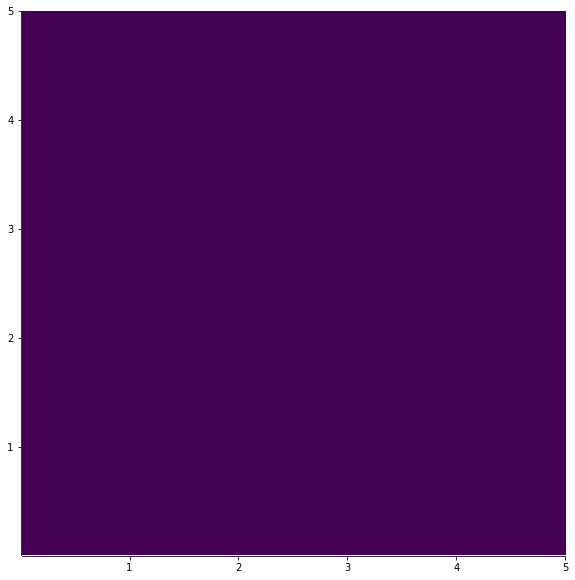

In [69]:
#x_ = (torch.arange(0.01, 5.01, 0.1))
#y_ = (torch.arange(0.01, 5.01, 0.1))
x_g, y_g = torch.meshgrid(x_, y_)
grid = torch.rot90(torch.stack((x_g, y_g), 2))

grid_search = torch.zeros((len(x_), len(y_)))
iter = 0
for i in range(len(x_)):
    break
    for j in range(len(y_)):
        iter += 1
        if iter%50 == 0:
            print(iter/25, "%")
        sample_point = grid[i][j]
        score = float(sample_regression(sample_point[0], sample_point[1])[0])
        #print(score)
        grid_search[i][j] = score
p, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.imshow(grid_search, extent=[x_[0], x_[-1], y_[0], y_[-1]])

ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.xlim(x_[0], x_[-1])
plt.ylim(y_[0], y_[-1])
plt.plot()